# Supervised learning predicting living status

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np

In [2]:
lung_cancer = pd.read_csv('lung_cancer_all_dummified.csv')

In [3]:
lung_cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2564 entries, 0 to 2563
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Study ID                   2564 non-null   int64  
 1   Cancer Type Detailed       2564 non-null   int64  
 2   Sex                        2564 non-null   int64  
 3   Age                        2564 non-null   int64  
 4   Smoking Status             2564 non-null   int64  
 5   Mutation Count             2564 non-null   int64  
 6   Fraction Genome Altered    2564 non-null   float64
 7   Overall Survival Status    2564 non-null   int64  
 8   Overall Survival (Months)  2564 non-null   float64
dtypes: float64(2), int64(7)
memory usage: 180.4 KB


In [4]:
lung_cancer.head()

,Study ID,Cancer Type Detailed,Sex,Age,Smoking Status,Mutation Count,Fraction Genome Altered,Overall Survival Status,Overall Survival (Months)
0,1,1,0,70,0,0,0.4565,0,0.00
1,1,1,0,81,0,0,0.0000,0,23.98
2,1,1,0,67,0,289,0.2221,0,50.03
3,1,1,1,79,0,0,0.2362,1,3.98
4,1,1,0,68,0,1272,0.0854,0,19.94


### Supervised learning on living status

- Logistic regression
- SVM
- Decision Tree
- Random Forest

##### preprocess the data

In [7]:
lung_cancer_new = lung_cancer.drop(columns = ['Study ID'])

In [9]:
X = lung_cancer_new.iloc[:, lung_cancer_new.columns != 'Overall Survival Status']
y = lung_cancer_new['Overall Survival Status']

In [10]:
#Logistic Regression
# Set up function parameters for different cross validation strategies
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5)
skfold = StratifiedKFold(n_splits=5, shuffle=True) 
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=1)

In [11]:
#Step 1: Split the data into training and testing set
from sklearn.model_selection import train_test_split

# randomly assign some data to the test-set and the rest to the training-set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42) 


In [13]:
#StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Logistic regression

In [15]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train_scaled, y_train)

print("Training set score: {:.2f}".format(logreg.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(logreg.score(X_test_scaled, y_test))) 

# Kfold Cross Validation
print("Mean Cross Validation, KFold: {:.2f}".format(np.mean(cross_val_score(logreg, X_train_scaled, y_train, cv=kfold))))

# Wine type prediction from test set (I'll use this later)
logreg_predicted_vals = logreg.predict(X_test_scaled)


Training set score: 0.74
Test set score: 0.74
Mean Cross Validation, KFold: 0.74


In [16]:
# GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

logreg_pipe = make_pipeline(StandardScaler(), LogisticRegression())
#print(logreg_pipe.steps) 
# Name of step = 'logisticregression' + __ + C

logreg_param_grid = {'logisticregression__C': np.linspace(1, 100, 100)}
logreg_grid = GridSearchCV(logreg_pipe, logreg_param_grid).fit(X_train_scaled, y_train)

print("Test set Score: {:.2f}".format(logreg_grid.score(X_test_scaled, y_test)))
print("Best Parameter: {}".format(logreg_grid.best_params_))

Test set Score: 0.74
Best Parameter: {'logisticregression__C': 1.0}


#### SVM

In [17]:
from sklearn import svm

svc = svm.SVC()
svc.fit(X_train, y_train)
print("Training set score: {:.2f}".format(svc.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(svc.score(X_test_scaled, y_test)))

# Kfold cross validation
print("Mean Cross-Validation, Kfold: {:.2f}".format(np.mean(cross_val_score(svc, X_train_scaled, y_train, scoring='r2', cv=kfold))))
svc_unscaled = np.mean(cross_val_score(svc, X_train_scaled, y_train, scoring='r2', cv=kfold))

Training set score: 0.75
Test set score: 0.74
Mean Cross-Validation, Kfold: -0.33


#### Decision Tree

In [18]:
from sklearn.tree import DecisionTreeClassifier

tree_class = DecisionTreeClassifier(random_state=0)
tree_class.fit(X_train_scaled, y_train)
tree_class.score(X_test_scaled, y_test)

0.8034321372854915

In [19]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

kfold = KFold(n_splits = 10, shuffle = True, random_state = 5)
max_depth = {'max_depth': np.arange(1, 20, 1)}
tree = DecisionTreeClassifier()
grid_dec_tree = GridSearchCV(tree, param_grid = max_depth, cv = kfold)
grid_dec_tree.fit(X_train_scaled, y_train)
cv_dec_tree = cross_val_score(grid_dec_tree, X_train_scaled, y_train)

print("Decision Tree Model KFold cross validation average score is: {:.3f}".format(np.mean(cv_dec_tree)))
print("Best mean cross-validation score of decision tree: {:.3f}".format(grid_dec_tree.best_score_))
print("Best parameter of decision tree: {}".format(grid_dec_tree.best_params_))

Decision Tree Model KFold cross validation average score is: 0.796
Best mean cross-validation score of decision tree: 0.816
Best parameter of decision tree: {'max_depth': 18}


#### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(random_state=0)
forest_classifier.fit(X_train_scaled, y_train)
forest_classifier.score(X_test_scaled, y_test)

0.8673946957878315

In [25]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

kfold = KFold(n_splits = 10, shuffle = True, random_state = 5)
max_depth = {'max_depth': np.arange(1, 20, 1)}
forest = RandomForestClassifier()
grid_forest = GridSearchCV(forest, param_grid = max_depth, cv = kfold)
grid_forest.fit(X_train_scaled, y_train)
cv_forest = cross_val_score(grid_forest, X_test_scaled, y_test)

print("Random Forest Model KFold cross validation average score is: {:.3f}".format(np.mean(cv_forest)))
print("Best mean cross-validation score of Random Forest: {:.3f}".format(grid_forest.best_score_))
print("Best parameter of Random Forest: {}".format(grid_forest.best_params_))

Random Forest Model KFold cross validation average score is: 0.771
Best mean cross-validation score of Random Forest: 0.858
Best parameter of Random Forest: {'max_depth': 19}


**Conclusion:**
- Random Forest has the highest score using the original model.
- The best parameter for random forest is when the max depth equals to 19.
- I just eliminated 'Study ID' and kept 'Cancer Type Detailed' to independent variables. I think Cancer Type may affect survival status. So I keep this variable.

#### Model Evaluation

In [29]:
from sklearn.metrics import confusion_matrix
test_pred_model_1 = grid_forest.predict(X_test_scaled) #model_1 test data predictions go here
cfm_model_1 = confusion_matrix(y_test, test_pred_model_1) #model_1 confusion matrix on test data goes here
train_acc_model_1 = grid_forest.score(X_train_scaled,y_train)
test_acc_model_1 = grid_forest.score(X_test_scaled,y_test)
print("Training accuracy: ",train_acc_model_1)
print("Testing  accuracy: ",test_acc_model_1)
print(cfm_model_1)

Training accuracy:  1.0
Testing  accuracy:  0.859594383775351
[[451  21]
 [ 69 100]]


In [30]:
from sklearn.metrics import f1_score,recall_score,precision_score
import warnings
warnings.filterwarnings('ignore')

f1_model_1 = f1_score(y_test, test_pred_model_1)#model_1 f1 score on test data goes here
precision_model_1 = recall_score(y_test, test_pred_model_1)#model_1 precision score on test data goes here
recall_model_1 = precision_score(y_test, test_pred_model_1)#model_1 recall score on test data goes here

print("precision: ",precision_model_1)
print("recall: ",recall_model_1)
print("f1 score: ",f1_model_1)

precision:  0.591715976331361
recall:  0.8264462809917356
f1 score:  0.6896551724137931


In [32]:
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
#clf = SGDClassifier(random_state=42,max_iter=100)
y_train_pred = cross_val_predict(grid_forest, X_train_scaled, y_train,cv=3)
precision,recall,thresholds = precision_recall_curve(y_train, y_train_pred)

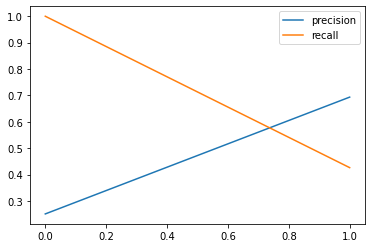

In [33]:
import matplotlib.pyplot as plt
plt.plot(thresholds,precision[:-1],label="precision")
plt.plot(thresholds,recall[:-1],label="recall")
plt.legend(["precision","recall"],loc="upper right")

- if precision is our focus, then, at around 60% we don't improve precision much but recall keeps dropping
- we could look for a threshold of around 0.75
- Boolean mask y_train_pred at around 0.75, i.e., predict 4 for values greater than 0.75 and not 4 for values less than 0.75

In [35]:
from sklearn.metrics import precision_score,recall_score
y_pred = y_train_pred > 0.75
print(precision_score(y_train, y_pred)) #originally 59%
print(recall_score(y_train, y_pred)) #originally 82%

0.6936026936026936
0.42650103519668736


- this gives us a precision of about 69%. That means that 69% of what we predicted as a 4 was actually a 4
- but we get a lower recal of less than 50%. Or, we correctly found less than 50% of all the 4s